# Quantum GAN com Pennylane e MedMNIST

Este notebook apresenta uma implementação simplificada de uma GAN quântica inspirada no método de *patches* descrito por Huang et al. Utilizamos o dataset **MedMNIST** para comparação com os modelos clássicos.

## 1. Setup Quântico
Instalação de `pennylane` e demais bibliotecas necessárias para execução do modelo híbrido.

In [1]:
!pip install pennylane pennylane-lightning torch medmnist matplotlib --quiet
import torch
import pennylane as qml
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt

## 2. Preparação do Dataset
Utilizamos o mesmo subset do notebook clássico para permitir comparação direta. Pode ser necessário reduzir a resolução das imagens para se adequar ao número de qubits disponíveis.

In [17]:
# Seleciona o dataset
DATA_FLAG = 'breastmnist'
info = INFO[DATA_FLAG]
download = True

transform = transforms.Compose([
    #transforms.Resize((8, 8)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# Carrega treino e teste
train_dataset = getattr(medmnist, info['python_class'])(split='train', transform=transform, download=download)
test_dataset = getattr(medmnist, info['python_class'])(split='test', transform=transform, download=download)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz


## 3. Implementação da Quantum GAN
Seguimos o tutorial da Pennylane para criar o gerador quântico por patches. O discriminador permanece clássico.

In [18]:
# Variáveis do circuito
n_qubits = 5
n_a_qubits = 1
q_depth = 6
n_generators = 49

class Discriminator(nn.Module):
    def __init__(self, img_size=8):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_size * img_size, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)


In [20]:
# Dispositivo quântico
dev = qml.device('lightning.qubit', wires=n_qubits)

@qml.qnode(dev, diff_method='parameter-shift')
def quantum_circuit(noise, weights):
    weights = weights.reshape(q_depth, n_qubits)
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)
    for i in range(q_depth):
        for j in range(n_qubits):
            qml.RY(weights[i][j], wires=j)
        for j in range(n_qubits-1):
            qml.CZ(wires=[j, j+1])
    return qml.probs(wires=list(range(n_qubits)))

def partial_measure(noise, weights):
    probs = quantum_circuit(noise, weights).clone().detach()
    probs_given = probs[:2 ** (n_qubits - n_a_qubits)]
    probs_given /= torch.sum(probs_given)
    probs_given = probs_given / torch.max(probs_given)
    return probs_given

In [19]:
class PatchQuantumGenerator(nn.Module):
    def __init__(self, n_generators, q_delta=1.):
        super().__init__()
        self.q_params = nn.ParameterList([
            nn.Parameter(q_delta*torch.rand(q_depth*n_qubits))
            for _ in range(n_generators)
        ])
        self.n_generators = n_generators

    def forward(self, x):
        patch_size = 2**(n_qubits-n_a_qubits)
        device = x.device  # garante que criamos tensores no dispositivo correto
        images = torch.empty(x.size(0), 0, device=device)
        for params in self.q_params:
            patches = torch.empty(0, patch_size, device=device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0).to(device)
                patches = torch.cat((patches, q_out))
            images = torch.cat((images, patches), 1)
        return images.view(x.size(0), 1, 28, 28)


## 4. Treinamento
Define a função de perda adversarial e executa um ciclo de treinamento simplificado.

Iter 1: Loss D 1.346, Loss G 0.724 — tempo iteração: 295.60s


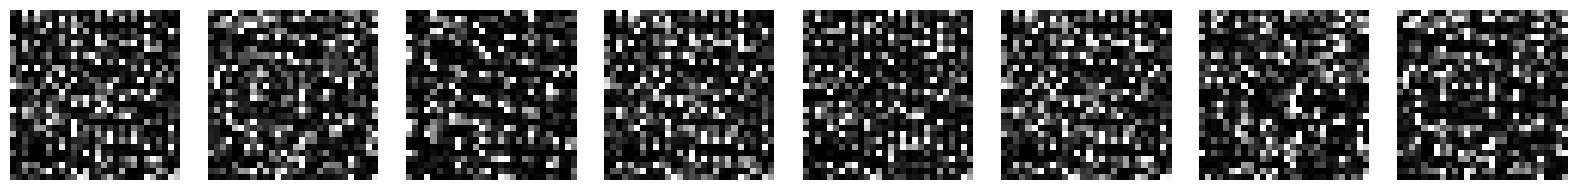

Tempo total de treinamento: 300.01s


In [22]:
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
D = Discriminator(img_size=28).to(device)
G = PatchQuantumGenerator(n_generators).to(device)

criterion = nn.BCELoss()
optD = torch.optim.SGD(D.parameters(), lr=1e-2)
optG = torch.optim.SGD(G.parameters(), lr=3e-1)

# Para medir o tempo total
total_start = time.time()

num_iter = 500
for it in range(num_iter):
    iter_start = time.time()  # marca início da iteração

    for real, _ in train_loader:
        real = real.to(device)
        b_size = real.size(0)

        # Labels dinâmicos
        real_label = torch.ones((b_size, 1), device=device)
        fake_label = torch.zeros((b_size, 1), device=device)

        # Gera fake
        noise = torch.rand(b_size, n_qubits, device=device) * torch.pi / 2
        fake = G(noise)

        # Treina D
        optD.zero_grad()
        out_real = D(real)
        out_fake = D(fake.detach())
        loss_D = criterion(out_real, real_label) + criterion(out_fake, fake_label)
        loss_D.backward()
        optD.step()

        # Treina G
        optG.zero_grad()
        out_fake = D(fake)
        loss_G = criterion(out_fake, real_label)
        loss_G.backward()
        optG.step()

    # fim da iteração
    iter_time = time.time() - iter_start
    print(f"Iter {it+1}: Loss D {loss_D.item():.3f}, Loss G {loss_G.item():.3f} — tempo iteração: {iter_time:.2f}s")

    # visualização só na primeira iteração, se quiser
    if (it + 1) % 50 == 0:
        noise_eval = torch.rand(8, n_qubits, device=device) * torch.pi/2
        with torch.no_grad():
            full_images = G(noise_eval).detach().cpu()
        fig, axes = plt.subplots(1, len(noise_eval), figsize=(len(noise_eval)*2, 2))
        for j, ax in enumerate(axes.flat):
            ax.imshow(full_images[j, 0], cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# depois de tudo
total_time = time.time() - total_start
print(f"Tempo total de treinamento: {total_time:.2f}s")

## 5. Avaliação
Utilize as mesmas métricas (FID e IS) para comparar as imagens geradas pela abordagem quântica.

In [ ]:
# Calcula FID e IS conforme mostrado no notebook clássico
# (exemplo de uso; pode requerer adaptação do tamanho dos lotes)

## 6. Visualização
Exibe amostras de imagens produzidas pelo gerador quântico.

In [ ]:
G.eval()
noise = torch.rand(8, n_qubits)*torch.pi/2
with torch.no_grad():
    samples = G(noise).cpu()

fig, axes = plt.subplots(1,8, figsize=(10,2))
for ax, img in zip(axes, samples):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis('off')
plt.show()

## 7. Conclusão
Apresentamos uma prova de conceito para GANs quânticas com o framework Pennylane. Avaliações adicionais podem ser realizadas comparando-se com as versões clássicas.